In [1]:
import h5py as h
import numpy as np

Cargamos las imágenes generadas por el código `delphes_gans`

In [2]:
f = h.File("new.h5", 'r')
images = np.vstack([f["qcd/images"][:], f["wprime/images"][:]])
labels = np.hstack([f["qcd/labels"][:], f["wprime/labels"][:]])

Acomodamos la información y separamos en datos de entrenamiento y de validación.

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

images = np.reshape(images, [-1, 25, 25, 1])
labels = to_categorical(labels)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True)

Las siguientes funciones ayudan a crear la red más flexible y rápida. Cada una de ellas define una nueva **capa** de la red. Entendemos como capa a cada operación del flujo de datos en la red.

In [4]:
def conv_layer(input, num_input_channels, filter_size, num_filters, name):
    with tf.variable_scope(name) as scope:
        shape   = [filter_size, filter_size, num_input_channels, num_filters]
        weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
        biases  = tf.Variable(tf.constant(0.05, shape=[num_filters]))
        layer   = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
        layer += biases
        
        return layer, weights
    
def pool_layer(input, name):
    with tf.variable_scope(name) as scope:
        layer = tf.nn.max_pool(value=input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        return layer

def relu_layer(input, name):    
    with tf.variable_scope(name) as scope:
        layer = tf.nn.relu(input)
        
        return layer
    
def fully_connected_layer(input, num_inputs, num_outputs, name):
    with tf.variable_scope(name) as scope:
        weights = tf.Variable(tf.truncated_normal([num_inputs, num_outputs], stddev=0.05))
        biases  = tf.Variable(tf.constant(0.05, shape=[num_outputs]))
        layer   = tf.matmul(input, weights) + biases
        
        return layer

Definimos la red

In [5]:
import tensorflow as tf

X = tf.placeholder(tf.float32, shape=[None, 25, 25, 1], name='X')
Y = tf.placeholder(tf.float32, shape=[None, 2], name='Y')

conv1, weights1 = conv_layer(X, num_input_channels=1, filter_size=5, num_filters=6, name="conv1")
pool1 = pool_layer(conv1, "pool1")
relu1 = relu_layer(pool1, "relu1")

conv2, weights2 = conv_layer(relu1, num_input_channels=6, filter_size=5, num_filters=16, name="conv2")
pool2 = pool_layer(conv2, "pool2")
relu2 = relu_layer(pool2, "relu2")

num_features = relu2.get_shape()[1:].num_elements()
layer_flat = tf.reshape(relu2, [-1, num_features])

layer_fc1 = fully_connected_layer(layer_flat, num_inputs=num_features, num_outputs=128, name="fc1")
layer_relu3 = relu_layer(layer_fc1, name="relu3")
layer_fc2 = fully_connected_layer(layer_relu3, num_inputs=128, num_outputs=2, name="fc2")

with tf.variable_scope("Softmax"):
    y_pred = tf.nn.softmax(layer_fc2)
    y_pred_cls = tf.argmax(y_pred, axis=1)

with tf.name_scope("cross_ent"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2, labels=Y)
    cost = tf.reduce_mean(cross_entropy)

with tf.name_scope("optimizer"):
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(cost)

with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(y_pred_cls, tf.argmax(Y, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

writer = tf.summary.FileWriter("C:/Usuarios/Olga/CNN_JetImages")
writer1 = tf.summary.FileWriter("C:/Usuarios/Olga/CNN_JetImages")

tf.summary.scalar('loss', cost)
tf.summary.scalar('accuracy', accuracy)
merged_summary = tf.summary.merge_all()

In [6]:
num_epochs = 300

ep = np.array([])
acc = np.array([])
loss = np.array([])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer.add_graph(sess.graph)

    for epoch in range(num_epochs):
        feed_dict_train = {X: x_train, Y: y_train}
        sess.run(optimizer, feed_dict=feed_dict_train)
        
        if epoch%5==0:
            train_summ, train_acc, train_loss = sess.run([merged_summary, accuracy, cost], feed_dict=feed_dict_train)
            val_summ, val_acc, val_loss = sess.run([merged_summary, accuracy, cost], feed_dict={X: x_test, Y: y_test})
            writer.add_summary(train_summ, epoch)
            writer1.add_summary(val_summ, epoch)
        
            saver = tf.train.Saver(max_to_keep=15)
            saver.save(sess,"cnn/epoch{:04}.ckpt".format((epoch)))
        
            ep = np.append(ep,epoch)
            acc = np.append(acc,train_acc)
            loss = np.append(loss,train_loss)

            
            print(f"Epoch {str(epoch)} completed")
            print ("\t- Training Accuracy:\t{}".format(train_acc))
            print ("\t- Validation Accuracy:\t{}".format(val_acc))
            print ("\t- Validation Loss:\t{}".format(val_loss))

Epoch 0 completed
	- Training Accuracy:	0.5097646713256836
	- Validation Accuracy:	0.5199999809265137
	- Validation Loss:	1.660599708557129
Epoch 5 completed
	- Training Accuracy:	0.4020196199417114
	- Validation Accuracy:	0.4011428654193878
	- Validation Loss:	0.6636123061180115
Epoch 10 completed
	- Training Accuracy:	0.7853672504425049
	- Validation Accuracy:	0.7817142605781555
	- Validation Loss:	0.6596007943153381
Epoch 15 completed
	- Training Accuracy:	0.7561208009719849
	- Validation Accuracy:	0.7649523615837097
	- Validation Loss:	0.6060104370117188
Epoch 20 completed
	- Training Accuracy:	0.7817471623420715
	- Validation Accuracy:	0.7695237994194031
	- Validation Loss:	0.5317918062210083
Epoch 25 completed
	- Training Accuracy:	0.8051824569702148
	- Validation Accuracy:	0.800761878490448
	- Validation Loss:	0.4657750129699707
Epoch 30 completed
	- Training Accuracy:	0.8325235843658447
	- Validation Accuracy:	0.8266666531562805
	- Validation Loss:	0.40843406319618225
Epoch 35 

Epoch 290 completed
	- Training Accuracy:	0.9689435362815857
	- Validation Accuracy:	0.9211428761482239
	- Validation Loss:	0.2593972384929657
Epoch 295 completed
	- Training Accuracy:	0.9723730683326721
	- Validation Accuracy:	0.9234285950660706
	- Validation Loss:	0.25491809844970703


In [7]:
import matplotlib.pyplot as plt
plt.plot(ep, acc)
plt.xlabel('epochs')
plt.ylabel('accuracy')

Text(0, 0.5, 'accuracy')

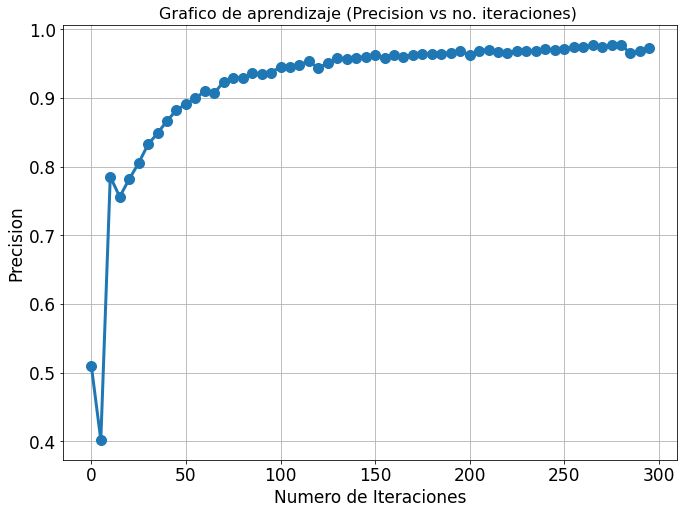

In [8]:
plt.rc('xtick',labelsize=17)
plt.rc('ytick',labelsize=17)
fig, ax = plt.subplots(figsize=(11,8))
ax.plot(ep, acc,marker = "o",linewidth=3,markersize=10)
ax.set_xlabel("Numero de Iteraciones",fontsize=17)
ax.set_ylabel("Precision",fontsize=17)
ax.set_title("Grafico de aprendizaje (Precision vs no. iteraciones) ",fontsize=16)
plt.grid()
plt.savefig('Accuracy_1e-2.jpeg')

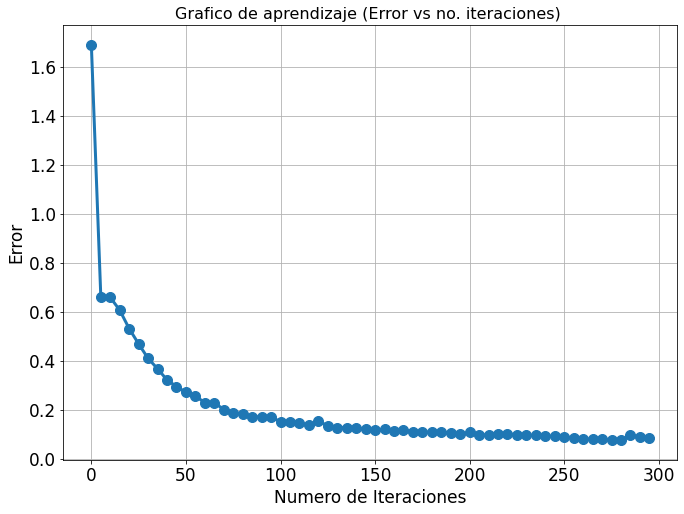

In [9]:
plt.rc('xtick',labelsize=17)
plt.rc('ytick',labelsize=17)
fig, ax = plt.subplots(figsize=(11,8))
ax.plot(ep, loss,marker = "o",linewidth=3,markersize=10)
ax.set_xlabel("Numero de Iteraciones",fontsize=17)
ax.set_ylabel("Error",fontsize=17)
ax.set_title("Grafico de aprendizaje (Error vs no. iteraciones) ",fontsize=16)
plt.grid()
plt.savefig('Loss_1e-2.jpeg')